In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from collections import Counter

In [2]:
data_path = 'e:/aihub/2_대화체_200226.xlsx'
df = pd.read_excel(data_path)

In [3]:
# Data를 list로 저장
SRC = df.원문.tolist()
TRG = df.번역문.apply(lambda x: x.lower()).tolist()

In [4]:
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<bos>'
EOS_TOKEN = '<eos>'

BATCH_SIZE = 64

- 단어사전을 구축한 다음에
- 풀고자하는 문장들을 해당 field에서 discrete token number로 mapping하지만
- 지금은 단지 base-line을 구축하기 위해 아래와 같이 간단하게 vocab을 구성하였다.

In [5]:
# spacing tokenizing
SRC_VOCAB = list(Counter([i for src in SRC for i in src.split(' ')]).keys())
TRG_VOCAB = list(Counter([i for trg in TRG for i in trg.split(' ')]).keys())

In [6]:
SRC_VOCAB = ['<unk>', '<pad>', '<bos>', '<eos>'] + SRC_VOCAB
TRG_VOCAB = ['<unk>', '<pad>', '<bos>', '<eos>'] + TRG_VOCAB

In [7]:
SRC_VOCAB_i = list(range(len(SRC_VOCAB)))
TRG_VOCAB_i = list(range(len(TRG_VOCAB)))

In [8]:
SRC_VOCAB_DICT = {i:j for i, j in zip(SRC_VOCAB, SRC_VOCAB_i)}
TRG_VOCAB_DICT = {i:j for i, j in zip(TRG_VOCAB, TRG_VOCAB_i)}

In [9]:
len(SRC_VOCAB_i), len(TRG_VOCAB_i)

(117303, 34308)

In [10]:
def sent2tokens(sents,
                vocab,
                tokenizer,
                init_token='<bos>',
                eos_token='<eos>',
                pad_token='<pad>',
                unk_token='<unk>'):
    bsz = len(sents)
    sents = list(map(tokenizer, sents))
    seg_length = [len(sent) for sent in sents]
    max_seq_len = max(seg_length) + 2 # BOS, EOS
    outputs = [[]] * bsz
    for ix, (sent, seg_len) in enumerate(zip(sents, seg_length)):
        output = [vocab[init_token]]
        output.extend([vocab.get(word, vocab[unk_token]) for word in sent])
        output.append(vocab[eos_token])
        if seg_len + 2 < max_seq_len: # BOS, EOS는 이미 추가
            output.extend(
                [vocab[pad_token]] * (max_seq_len - len(output)))
        outputs[ix] = output
    return outputs

def make_iterator(data, vocab, tokenizer,
                  batch_size=32,
                  init_token='<bos>',
                  eos_token='<eos>',
                  pad_token='<pad>',
                  unk_token='<unk>'):
    bsz = batch_size
    n_iter = len(data) // bsz
    for i in range(n_iter+1):
        batch_data = data[i*bsz:(i+1)*bsz] if i < n_iter else data[i*bsz:]
        if batch_data == []: break
        outputs = sent2tokens(batch_data, vocab, tokenizer)
        yield i, batch_data, outputs

In [11]:
tokenizer = lambda s: s.split(' ')

In [12]:
def get_rand_ind(len_pairs, n):
    buffer = []
    for i in range(n):
        sample = random.choice(list(range(len_pairs)))
        while sample not in buffer:
            sample = random.choice(list(range(len_pairs)))
            buffer.append(sample)
    return buffer

def sampling(li, ind):
    output = []
    for i in ind:
        output.append(li[i])
    return output

In [18]:
assert len(SRC) == len(TRG)
# ind = get_rand_ind(len(SRC), 5)
# ind = [24370, 9983, 31193, 83814, 56242]
# ind = [69966, 10151, 97861, 99329, 36490]
ind = [26731, 66287, 256, 58182, 11931]
src_generator = make_iterator(sampling(SRC, ind), 
                              SRC_VOCAB_DICT, 
                              tokenizer, 
                              batch_size=BATCH_SIZE)
trg_generator = make_iterator(sampling(TRG, ind), 
                              TRG_VOCAB_DICT, 
                              tokenizer, 
                              batch_size=BATCH_SIZE)

In [19]:
_, src_origin, src_input_exam = next(src_generator)
_, trg_origin, trg_input_exam = next(trg_generator)

In [20]:
ind

[26731, 66287, 256, 58182, 11931]

In [21]:
src_origin

['15명 이상의 관람객을 단체 관람객으로 분류하고 있습니다.',
 '비가 오면 정말 번거로워지는 것 같아.',
 '부산 출장이 2주후로 다가왔습니다. 다들 준비는 착오없이 진행되고 있나요?',
 '거기 놓치면 절대 안 돼요, 내일 가져가기로 했던 계약서는 봤어요?',
 '별말씀을요. 혹시 이상 있으면 찾아오세요.']

In [22]:
src_input_exam

[[2, 10549, 3900, 45910, 3680, 45908, 2282, 16, 3, 1, 1, 1],
 [2, 2977, 5923, 956, 88842, 39, 2539, 3, 1, 1, 1, 1],
 [2, 1230, 1231, 1232, 1233, 323, 1234, 1235, 1236, 110, 3, 1],
 [2, 6726, 22523, 2457, 804, 61496, 105, 78511, 1664, 11442, 71906, 3],
 [2, 3085, 394, 2615, 133, 26667, 3, 1, 1, 1, 1, 1]]

In [23]:
trg_origin

['we classify an audience of more than 15 people as a group audience.',
 "it's such a bother when it rains.",
 "we will be going to busan in 2 weeks. how's our preparation looking like?",
 'we cannot lose them, did you take a look at the contract to take tomorrow?',
 'no problem. please come back if you have any problems.']

In [24]:
trg_input_exam

[[2, 34, 17571, 475, 3318, 26, 51, 16, 3829, 258, 94, 31, 572, 12917, 3, 1, 1],
 [2, 116, 1152, 31, 3749, 184, 83, 17759, 3, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 34, 190, 139, 121, 9, 946, 62, 86, 793, 947, 55, 948, 279, 949, 3, 1],
 [2, 34, 1486, 8234, 474, 459, 66, 35, 31, 36, 37, 6, 1062, 9, 35, 125, 3],
 [2, 1358, 612, 151, 168, 1012, 146, 66, 21, 147, 2388, 3, 1, 1, 1, 1, 1]]

In [25]:
x = torch.LongTensor(src_input_exam)
y = torch.LongTensor(trg_input_exam)

In [26]:
x_ = torch.LongTensor(src_input_exam)
y_ = torch.LongTensor(trg_input_exam)

mask_x = x_ > 3
x_[mask_x] = x_[mask_x] / x_[mask_x].sum()
mask_y = y_ > 3
y_[mask_y] = y_[mask_y] / y_[mask_y].sum()

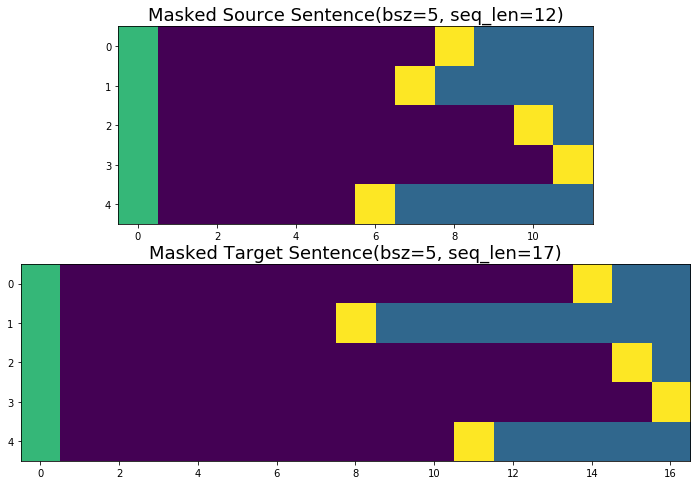

In [27]:
fig = plt.figure(figsize=(12, 8), facecolor='w')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.imshow(x_.detach().numpy())
ax2.imshow(y_.detach().numpy())
ax1.set_title(f'Masked Source Sentence(bsz=5, seq_len={x_.size(1)})', fontsize=18)
ax2.set_title(f'Masked Target Sentence(bsz=5, seq_len={y_.size(1)})', fontsize=18)
plt.show()

Set HyperParameter of Transformer

In [28]:
INPUT_SIZE   = len(SRC_VOCAB_DICT)
OUTPUT_SIZE  = len(TRG_VOCAB_DICT)
HIDDEN_SIZE  = 256
N_SPLITS     = 8
N_ENC_BLOCKS = 6
N_DEC_BLOCKS = 6
DROPOUT_P    = 0.2

Start Transformer's Forward!

In [29]:
x

tensor([[    2, 10549,  3900, 45910,  3680, 45908,  2282,    16,     3,     1,
             1,     1],
        [    2,  2977,  5923,   956, 88842,    39,  2539,     3,     1,     1,
             1,     1],
        [    2,  1230,  1231,  1232,  1233,   323,  1234,  1235,  1236,   110,
             3,     1],
        [    2,  6726, 22523,  2457,   804, 61496,   105, 78511,  1664, 11442,
         71906,     3],
        [    2,  3085,   394,  2615,   133, 26667,     3,     1,     1,     1,
             1,     1]])

In [31]:
# make mask
mask = []
length = (x != 1).sum(dim=-1).tolist()
max_length = max(length)
for l in length:
    if max_length - l > 0:
        mask += [torch.cat([x.new_ones(1, l).zero_(),
                            x.new_ones(1, (max_length-l))
                           ], dim=-1)]
    else:
        mask += [x.new_ones(1, l).zero_()]
mask = torch.cat(mask, dim=0).bool()
mask # |mask| = (batch_size, n)

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True]])

In [32]:
x == SRC_VOCAB_DICT[PAD_TOKEN] # it is same to mask

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True]])

In [33]:
mask_enc = mask.unsqueeze(1).expand(mask.size(0), x.size(1), mask.size(-1))
mask_dec = mask.unsqueeze(1).expand(mask.size(0), y.size(1), mask.size(-1))

print(f"|mask_enc|={mask_enc.shape}=(batch_size, n, n)\n"
      f"|mask_dec|={mask_dec.shape}=(batch_size, m, n)")

|mask_enc|=torch.Size([5, 12, 12])=(batch_size, n, n)
|mask_dec|=torch.Size([5, 17, 12])=(batch_size, m, n)


$\text{EmbEncLayer}=\mathbb{N}_{[0,input\_size-1]} \rightarrow \mathbb{R}^{hidden\_size}$

In [35]:
# discrete token -> continuous token
# \mathbb{N}_{[0,input_size-1]} -> \mathbb{R}^{hidden_size}
emb_enc = nn.Embedding(INPUT_SIZE, HIDDEN_SIZE)
emb_enc.weight.size()

torch.Size([117303, 256])

In [36]:
embedded_x = emb_enc(x)
print(f"|emb_enc(x)|={embedded_x.shape}=(batch_size,n,hidden_size)")

|emb_enc(x)|=torch.Size([5, 12, 256])=(batch_size,n,hidden_size)


In [98]:
# _position_encoding
length, hidden_size = embedded_x.size()[1:]
print(f"length: {length} | hidden_size: {hidden_size}")
enc = embedded_x.new_zeros(embedded_x.shape[1:])
print(f"|enc|={enc.shape}=(n,hidden_size)")
init_pos = 0 # argument, default is 0
pos = init_pos + torch.arange(0, length).unsqueeze(-1)
dim = (10000. ** (torch.arange(0, hidden_size//2).div(hidden_size))).unsqueeze(0)

length: 12 | hidden_size: 256
|enc|=torch.Size([12, 256])=(n,hidden_size)


In [106]:
pos_emb = torch.arange(0, length).unsqueeze(-1).expand(length, 256)
pos_emb = pos_emb.float()
pos_emb

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 2.,  2.,  2.,  ...,  2.,  2.,  2.],
        ...,
        [ 9.,  9.,  9.,  ...,  9.,  9.,  9.],
        [10., 10., 10.,  ..., 10., 10., 10.],
        [11., 11., 11.,  ..., 11., 11., 11.]])

In [107]:
even = (pos_emb % 2) == 0
odd  = (pos_emb % 2) == 1

In [108]:
pos_emb[even] = torch.sin(pos_emb[even] / (10000.**(pos_emb[even]/hidden_size)))
pos_emb[odd]  = torch.sin(pos_emb[odd] / (10000.**(pos_emb[odd]/hidden_size)))

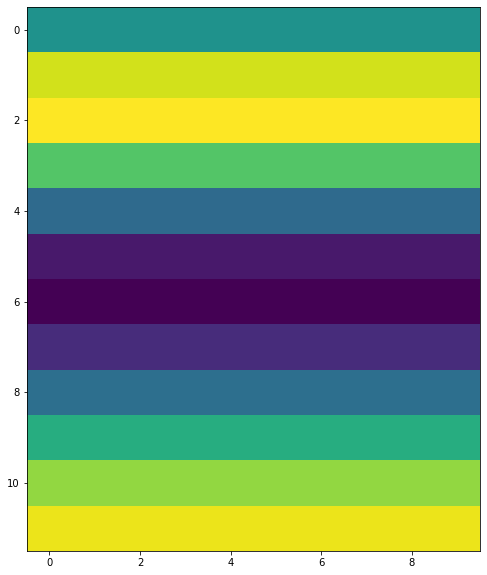

In [114]:
plt.figure(figsize=(10,10))
plt.imshow(pos_emb.detach().numpy()[:,:10])